In [1]:
# Import modules
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import cv2
import os
import math
import time
from scipy.io import loadmat
from matplotlib import pyplot as plt

In [6]:
# Load training data that were cropped and resized in MATLAB
def load_STONE_data(folder, n_cases, normalize=False, imrotate=False):
    """
    """
    temp = loadmat(os.path.join(folder, 'Stone_all_crop_64'))['crop_data_resize']
    row, col, t1w, sli, n = temp.shape
    temp = np.reshape(temp[:,:,:,:,n_cases[0]:n_cases[1]], (row, col, -1))
    bigy = np.transpose(temp, (2,0,1))
    
    # convert to k-space
    imgs, row, col = bigy.shape
    bigx = np.empty((imgs, row, col, 2))
    for i in range(imgs):
        bigx[i, :, :, :] = create_x(np.squeeze(bigy[i,:,:]), normalize=False)
        
    # convert bigx from complex to abs values
    bigy = np.abs(bigy)
    
    return bigx, bigy

def create_x(y, normalize=False):
    """
    Prepares frequency data from image data: applies to_freq_space,
    expands the dimensions from 3D to 4D, and normalizes if normalize=True
    :param y: input image
    :param normalize: if True - the frequency data will be normalized
    :return: frequency data 4D array of size (1, im_size1, im_size2, 2)
    """
    x = to_freq_space(y)  # FFT: (128, 128, 2)
    x = np.expand_dims(x, axis=0)  # (1, 128, 128, 2)
    if normalize:
        x = x - np.mean(x)

    return x


def to_freq_space(img):
    """ Performs FFT of an image
    :param img: input 2D image
    :return: Frequency-space data of the input image, third dimension (size: 2)
    contains real ans imaginary part
    """

    img_f = np.fft.fft2(img)  # FFT
    img_fshift = np.fft.fftshift(img_f)  # FFT shift
    img_real = img_fshift.real  # Real part: (im_size1, im_size2)
    img_imag = img_fshift.imag  # Imaginary part: (im_size1, im_size2)
    img_real_imag = np.dstack((img_real, img_imag))  # (im_size1, im_size2, 2)

    return img_real_imag


tic1 = time.time()
# Folder with images
dir_train = "/home/chongduan/Documents/11_AUTOMAP/Dataset"  
n_cases = (0,3) # load data from 0-3 patients
X_train, Y_train = load_STONE_data(  # Load images for training
    dir_train,
    n_cases,
    normalize=False,
    imrotate=False)
toc1 = time.time()
print('Time to load data = ', (toc1 - tic1))
print('X_train.shape at input = ', X_train.shape)
print('Y_train.shape at input = ', Y_train.shape)


Time to load data =  5.508875846862793
X_train.shape at input =  (165, 64, 64, 2)
Y_train.shape at input =  (165, 64, 64)


In [3]:
# Define the AUTOMAP Neural Network Model
def create_placeholders(n_H0, n_W0):
    """ Creates placeholders for x and y for tf.session
    :param n_H0: image height
    :param n_W0: image width
    :return: x and y - tf placeholders
    """

    x = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, 2], name='x')
    y = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0], name='y')

    return x, y

def initialize_parameters():
    """ Initializes filters for the convolutional and de-convolutional layers
    :return: parameters - a dictionary of filters (W1 - first convolutional
    layer, W2 - second convolutional layer, W3 - de-convolutional layer
    """

    W1 = tf.get_variable("W1", [5, 5, 1, 64],  # 64 filters of size 5x5
                         initializer=tf.contrib.layers.xavier_initializer
                         (seed=0))
    W2 = tf.get_variable("W2", [5, 5, 64, 64],  # 64 filters of size 5x5
                         initializer=tf.contrib.layers.xavier_initializer
                         (seed=0))
    W3 = tf.get_variable("W3", [7, 7, 64, 1],  # 64 filters of size 7x7
                         initializer=tf.contrib.layers.xavier_initializer
                         (seed=0))  # set to std conv2d, Chong Duan

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}

    return parameters


def forward_propagation(x, parameters):
    """ Defines all layers for forward propagation:
    Fully connected (FC1) -> tanh activation: size (n_im, n_H0 * n_W0)
    -> Fully connected (FC2) -> tanh activation:  size (n_im, n_H0 * n_W0)
    -> Convolutional -> ReLU activation: size (n_im, n_H0, n_W0, 64)
    -> Convolutional -> ReLU activation with l1 regularization: size (n_im, n_H0, n_W0, 64)
    -> De-convolutional: size (n_im, n_H0, n_W0)
    :param x: Input - images in frequency space, size (n_im, n_H0, n_W0, 2)
    :param parameters: parameters of the layers (e.g. filters)
    :return: output of the last layer of the neural network
    """

    x_temp = tf.contrib.layers.flatten(x)  # size (n_im, n_H0 * n_W0 * 2)
    n_out = np.int(x.shape[1] * x.shape[2])  # size (n_im, n_H0 * n_W0)

#    with tf.device('/gpu:0'):
    with tf.device('/cpu:0'):
        # FC: input size (n_im, n_H0 * n_W0 * 2), output size (n_im, n_H0 * n_W0)
        FC1 = tf.contrib.layers.fully_connected(
            x_temp,
            n_out,
            activation_fn=tf.tanh,
            normalizer_fn=None,
            normalizer_params=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=None,
            biases_initializer=None,
            biases_regularizer=None,
            reuse=tf.AUTO_REUSE,
            variables_collections=None,
            outputs_collections=None,
            trainable=True,
            scope='fc1')

    with tf.device('/cpu:0'):
        # FC: input size (n_im, n_H0 * n_W0), output size (n_im, n_H0 * n_W0)
        FC2 = tf.contrib.layers.fully_connected(
            FC1,
            n_out,
            activation_fn=tf.tanh,
            normalizer_fn=None,
            normalizer_params=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            weights_regularizer=None,
            biases_initializer=None,
            biases_regularizer=None,
            reuse=tf.AUTO_REUSE,
            variables_collections=None,
            outputs_collections=None,
            trainable=True,
            scope='fc2')

    # Reshape output from FC layers into array of size (n_im, n_H0, n_W0, 1):
    FC_M = tf.reshape(FC2, [tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], 1])

    # Retrieve the parameters from the dictionary "parameters":
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    # CONV2D: filters W1, stride of 1, padding 'SAME'
    # Input size (n_im, n_H0, n_W0, 1), output size (n_im, n_H0, n_W0, 64)
    Z1 = tf.nn.conv2d(FC_M, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    CONV1 = tf.nn.relu(Z1)

    # CONV2D: filters W2, stride 1, padding 'SAME'
    # Input size (n_im, n_H0, n_W0, 64), output size (n_im, n_H0, n_W0, 64)
    Z2 = tf.nn.conv2d(CONV1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    CONV2 = tf.nn.relu(Z2)
    
#    CONV2 = tf.layers.conv2d(
#        CONV1,
#        filters=64,
#        kernel_size=5,
#        strides=(1, 1),
#        padding='same',
#        data_format='channels_last',
#        dilation_rate=(1, 1),
#        activation=tf.nn.relu,
#        use_bias=True,
#        kernel_initializer=None,
#        bias_initializer=tf.zeros_initializer(),
#        kernel_regularizer=None,
#        bias_regularizer=None,
#        activity_regularizer=None,
##        activity_regularizer=tf.contrib.layers.l1_regularizer(0.0001),
#        kernel_constraint=None,
#        bias_constraint=None,
#        trainable=True,
#        name='conv2',
#        reuse=tf.AUTO_REUSE)

#    # DE-CONV2D: filters W3, stride 1, padding 'SAME'
#    # Input size (n_im, n_H0, n_W0, 64), output size (n_im, n_H0, n_W0, 1)
#    batch_size = tf.shape(x)[0]
#    deconv_shape = tf.stack([batch_size, x.shape[1], x.shape[2], 1])
#    DECONV = tf.nn.conv2d_transpose(CONV2, W3, output_shape=deconv_shape,
#                                    strides=[1, 1, 1, 1], padding='SAME')
    
    
#    # Use conv for the last layer, Chong Duan
#    Z2 = tf.nn.conv2d(CONV2, W3, strides=[1, 1, 1, 1], padding='SAME')
#    # RELU
#    CONV3 = tf.nn.relu(Z2)
    
    # Apply L1-norm on last hidden layer to the activation as described in the paper
    CONV3 = tf.layers.conv2d(
        CONV2,
        filters=1,
        kernel_size=7,
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        dilation_rate=(1, 1),
        activation=tf.nn.relu,
        use_bias=True,
        kernel_initializer=None,
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer = None,
#        activity_regularizer=tf.contrib.layers.l1_regularizer(0.0001),
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
        name='conv3',
        reuse=tf.AUTO_REUSE)
    
    DECONV = tf.squeeze(CONV3)

    return DECONV


def compute_cost(DECONV, Y):
    """
    Computes cost (squared loss) between the output of forward propagation and
    the label image
    :param DECONV: output of forward propagation
    :param Y: label image
    :return: cost (squared loss)
    """

    cost = tf.square(DECONV - Y)

    return cost


def random_mini_batches(x, y, mini_batch_size=64, seed=0):
    """ Shuffles training examples and partitions them into mini-batches
    to speed up the gradient descent
    :param x: input frequency space data
    :param y: input image space data
    :param mini_batch_size: mini-batch size
    :param seed: can be chosen to keep the random choice consistent
    :return: a mini-batch of size mini_batch_size of training examples
    """

    m = x.shape[0]  # number of input images
    mini_batches = []
    np.random.seed(seed)

    # Shuffle (x, y)
    permutation = list(np.random.permutation(m))
    shuffled_X = x[permutation, :]
    shuffled_Y = y[permutation, :]

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(
        m / mini_batch_size))  # number of mini batches of size mini_batch_size

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:k * mini_batch_size
                                    + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:k * mini_batch_size
                                    + mini_batch_size, :, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches
                                  * mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches
                                  * mini_batch_size: m, :, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def model(X_train, Y_train, learning_rate=0.0001,
          num_epochs=100, minibatch_size=5, print_cost=True):
    """ Runs the forward and backward propagation
    :param X_train: input training frequency-space data
    :param Y_train: input training image-space data
    :param learning_rate: learning rate of gradient descent
    :param num_epochs: number of epochs
    :param minibatch_size: size of mini-batch
    :param print_cost: if True - the cost will be printed every epoch, as well
    as how long it took to run the epoch
    :return: this function saves the model to a file. The model can then
    be used to reconstruct the image from frequency space
    """

    with tf.device('/cpu:0'):
        ops.reset_default_graph()  # to not overwrite tf variables
        seed = 3
        (m, n_H0, n_W0, _) = X_train.shape

        # Create Placeholders
        X, Y = create_placeholders(n_H0, n_W0)

        # Initialize parameters
        parameters = initialize_parameters()

        # Build the forward propagation in the tf graph
        DECONV = forward_propagation(X, parameters)

        # Add cost function to tf graph
        cost = compute_cost(DECONV, Y)
        
#        # Backpropagation
#        optimizer = tf.train.RMSPropOptimizer(learning_rate,
#                                              decay=0.9,
#                                              momentum=0.0).minimize(cost)
        
        # Backpropagation
        # Add global_step variable for save training models - Chong Duan
        my_global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        optimizer = tf.train.RMSPropOptimizer(learning_rate,
                                              decay=0.9,
                                              momentum=0.0).minimize(cost, global_step = my_global_step)

        # Initialize all the variables globally
        init = tf.global_variables_initializer()

        # Add ops to save and restore all the variables
        saver = tf.train.Saver(save_relative_paths=True)

        # For memory
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        # Memory config
        #config = tf.ConfigProto()
        #config.gpu_options.allow_growth = True
        config = tf.ConfigProto(log_device_placement=True)

        # Start the session to compute the tf graph
        with tf.Session(config=config) as sess:

            # Initialization
            sess.run(init)

            # Training loop
            learning_curve = []
            for epoch in range(num_epochs):
                tic = time.time()

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size)  # number of minibatches
                seed += 1
                minibatches = random_mini_batches(X_train, Y_train,
                                                  minibatch_size, seed)
                # Minibatch loop
                for minibatch in minibatches:
                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # Run the session to execute the optimizer and the cost
                    _, temp_cost = sess.run(
                        [optimizer, cost],
                        feed_dict={X: minibatch_X, Y: minibatch_Y})

                    cost_mean = np.mean(temp_cost) / num_minibatches
                    minibatch_cost += cost_mean

                # Print the cost every epoch
                learning_curve.append(minibatch_cost)
                if print_cost:
                    toc = time.time()
                    print ('EPOCH = ', epoch, 'COST = ', minibatch_cost, 'Elapsed time = ', (toc - tic))
                    
                if (epoch + 1) % 10 == 0:
                    save_path = saver.save(sess, './checkpoints_jupyter/model.ckpt', global_step = my_global_step)
                    print("Model saved in file: %s" % save_path)


#            # Save the variables to disk.
#            save_path = saver.save(sess, './model/' + 'model.ckpt')
#            print("Model saved in file: %s" % save_path)
            
            # Plot learning curve
            plt.plot(learning_curve)
            plt.title('Learning Curve')
            plt.xlabel('Epoch')
            plt.ylabel('Cost')
            plt.show()
            
            # Close sess
            sess.close()

EPOCH =  0 COST =  5025.5474609375 Elapsed time =  29.99897313117981
EPOCH =  1 COST =  4399.864990234375 Elapsed time =  24.899394273757935
EPOCH =  2 COST =  3328.541560872396 Elapsed time =  25.981924533843994
EPOCH =  3 COST =  2281.7478922526043 Elapsed time =  27.172335624694824
EPOCH =  4 COST =  1667.9049153645835 Elapsed time =  24.565744638442993
EPOCH =  5 COST =  1377.987263997396 Elapsed time =  24.737321853637695
EPOCH =  6 COST =  1162.266560872396 Elapsed time =  25.029865741729736
EPOCH =  7 COST =  984.1075561523438 Elapsed time =  26.455872058868408
EPOCH =  8 COST =  849.1163614908854 Elapsed time =  27.033984899520874
EPOCH =  9 COST =  747.9587687174479 Elapsed time =  25.857618808746338
Model saved in file: ./checkpoints_test/model.ckpt-150


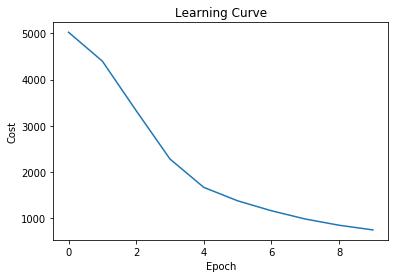

In [4]:
# Finally run the model!
model(X_train, Y_train,
#      learning_rate=0.00002,
      learning_rate=0.0001,
      num_epochs=10,
      minibatch_size=11,  # should be < than the number of input examples
      print_cost=True)

X_dev.shape at input =  (55, 64, 64, 2)
Y_dev.shape at input =  (55, 64, 64)
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-44000
Model restored
Y_recon.shape =  (55, 64, 64)
Y_dev.shape =  (55, 64, 64)


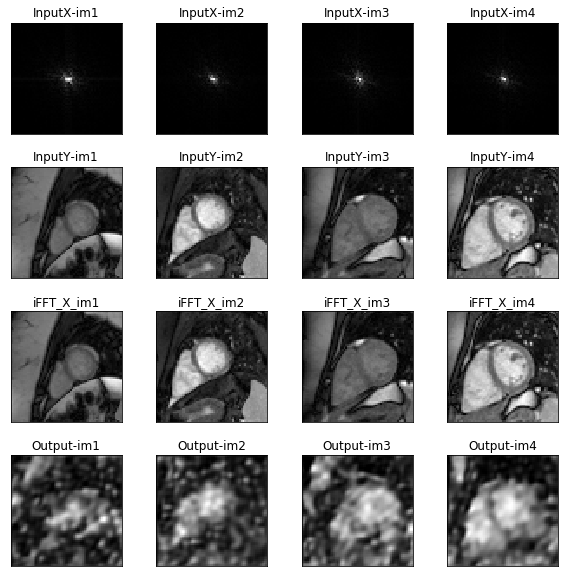

In [10]:
### Evaluate the model

# Prepare test data
dir_train = "/home/chongduan/Documents/11_AUTOMAP/Dataset"  
n_cases = (51,52) 
X_dev, Y_dev = load_STONE_data(  # Load images for training
    dir_train,
    n_cases,
    normalize=False,
    imrotate=False)
print('X_dev.shape at input = ', X_dev.shape)
print('Y_dev.shape at input = ', Y_dev.shape)

def model_predict(X_dev):
    """ Runs the forward propagation to reconstruct images using trained model
    :param X_dev: input development frequency-space data
    :return: returns the image, reconstructed using a trained model
    """
    with tf.device('/cpu:0'):
        ops.reset_default_graph()  # to not overwrite tf variables
        (_, n_H0, n_W0, _) = X_dev.shape
    
        # Create Placeholders
        X, Y = create_placeholders(n_H0, n_W0)
    
        # Initialize parameters
        parameters = initialize_parameters()
    
        # Build the forward propagation in the tf graph
        forward_propagation(X, parameters)
        
        # Add ops to save and restore all the variables
        saver = tf.train.Saver()
    
        # Start the session to compute the tf graph
        with tf.Session() as sess:
            
            # Chong Duan
            ckpt = tf.train.get_checkpoint_state('./checkpoints_jupyter/')
            saver.restore(sess, ckpt.model_checkpoint_path)

            print("Model restored")
    
            Y_recon_temp = forward_propagation(X, parameters)
            Y_recon = Y_recon_temp.eval({X: X_dev})
    
        return parameters, Y_recon

# Reconstruct the image using trained model
_, Y_recon = model_predict(X_dev)
print('Y_recon.shape = ', Y_recon.shape)
print('Y_dev.shape = ', Y_dev.shape)


# Visualize the images, their reconstruction using iFFT and using trained model
# 4 images to visualize:
im1 = 15
im2 = 16
im3 = 17
im4 = 18

# iFFT back to image from corrupted frequency space
# Complex image from real and imaginary part
X_dev_compl = X_dev[:, :, :, 0] + X_dev[:, :, :, 1] * 1j

#iFFT
X_iFFT0 = np.fft.ifft2(X_dev_compl[im1, :, :])
X_iFFT1 = np.fft.ifft2(X_dev_compl[im2, :, :])
X_iFFT2 = np.fft.ifft2(X_dev_compl[im3, :, :])
X_iFFT3 = np.fft.ifft2(X_dev_compl[im4, :, :])

# Magnitude of complex image
X_iFFT_M1 = np.sqrt(np.power(X_iFFT0.real, 2)
                    + np.power(X_iFFT0.imag, 2))
X_iFFT_M2 = np.sqrt(np.power(X_iFFT1.real, 2)
                    + np.power(X_iFFT1.imag, 2))
X_iFFT_M3 = np.sqrt(np.power(X_iFFT2.real, 2)
                    + np.power(X_iFFT2.imag, 2))
X_iFFT_M4 = np.sqrt(np.power(X_iFFT3.real, 2)
                    + np.power(X_iFFT3.imag, 2))

# Display results
# Show X - input k-space
plt.figure(figsize = (10,10))
plt.subplot(441), plt.imshow(np.abs(X_dev_compl[im1, :, :]), cmap='gray')
plt.title('InputX-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(442), plt.imshow(np.abs(X_dev_compl[im2, :, :]), cmap='gray')
plt.title('InputX-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(443), plt.imshow(np.abs(X_dev_compl[im3, :, :]), cmap='gray')
plt.title('InputX-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(444), plt.imshow(np.abs(X_dev_compl[im4, :, :]), cmap='gray')
plt.title('InputX-im4'), plt.xticks([]), plt.yticks([])

# Show Y - ground truth
plt.subplot(445), plt.imshow(Y_dev[im1, :, :], cmap='gray')
plt.title('InputY-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(446), plt.imshow(Y_dev[im2, :, :], cmap='gray')
plt.title('InputY-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(447), plt.imshow(Y_dev[im3, :, :], cmap='gray')
plt.title('InputY-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(448), plt.imshow(Y_dev[im4, :, :], cmap='gray')
plt.title('InputY-im4'), plt.xticks([]), plt.yticks([])

# Show images reconstructed using iFFT
plt.subplot(449), plt.imshow(X_iFFT_M1, cmap='gray')
plt.title('iFFT_X_im1'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,10), plt.imshow(X_iFFT_M2, cmap='gray')
plt.title('iFFT_X_im2'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,11), plt.imshow(X_iFFT_M3, cmap='gray')
plt.title('iFFT_X_im3'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,12), plt.imshow(X_iFFT_M4, cmap='gray')
plt.title('iFFT_X_im4'), plt.xticks([]), plt.yticks([])

# Show images reconstructed using neural network
plt.subplot(4,4,13), plt.imshow(Y_recon[im1, :, :], cmap='gray')
plt.title('Output-im1'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,14), plt.imshow(Y_recon[im2, :, :], cmap='gray')
plt.title('Output-im2'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,15), plt.imshow(Y_recon[im3, :, :], cmap='gray')
plt.title('Output-im3'), plt.xticks([]), plt.yticks([])
plt.subplot(4,4,16), plt.imshow(Y_recon[im4, :, :], cmap='gray')
plt.title('Output-im4'), plt.xticks([]), plt.yticks([])
plt.subplots_adjust(hspace=0.3)
plt.show()